In [3]:
import pickle
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

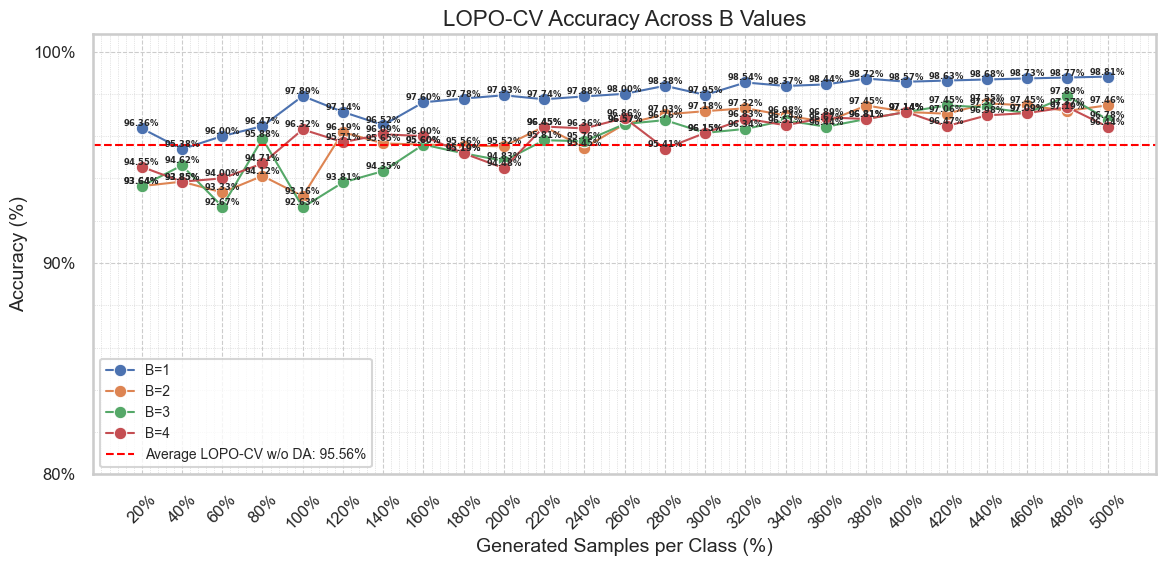

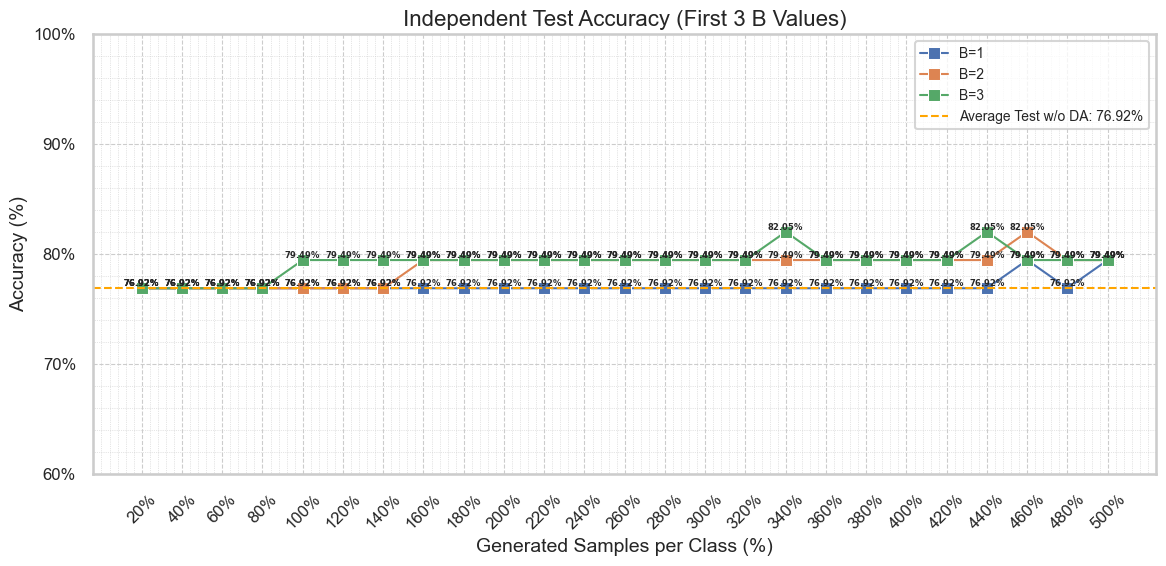

In [5]:
# 2. 載入所有歷史紀錄
histories = []
for p in paths:
    with open(p, 'rb') as f:
        histories.append(pickle.load(f))

# 3. 提取 gen_counts, LOPO-CV 和獨立測試分數
gen_counts = np.array(histories[0]['gen_counts'])
loocv_matrix = np.array([h['loocv_scores'] for h in histories]) * 100  # shape (4, N)
test_matrix  = np.array([h['test_scores']  for h in histories]) * 100  # shape (4, N)
labels = [f'B={i+1}' for i in range(len(histories))]

# -----------------------------------------------------------------------------
# 4. 繪製一張圖：全部 4 條 LOPO-CV 折線
# -----------------------------------------------------------------------------
# Flatten 取極值以決定 y 軸範圍
all_loocv = loocv_matrix.flatten()
min_val = all_loocv.min()
lower = max(int(np.floor((min_val - 10)/10)) * 10, 0)
upper = min(all_loocv.max() + 2, 102)

sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 6))

for idx, loocv in enumerate(loocv_matrix):
    sns.lineplot(
        x=gen_counts, y=loocv,
        marker="o", linewidth=1.5,
        label=labels[idx], ax=ax, clip_on=False
    )
    # 加上每個點的數值標註
    for x, y in zip(gen_counts, loocv):
        ax.text(
            x, y, f"$\\mathbf{{{y:.2f}\\%}}$",
            va='bottom', ha='center',
            fontsize=6, clip_on=False
        )

# 加入 LOPO-CV 無 DA 的基準線
baseline = 95.56
ax.axhline(
    baseline, linestyle='--',
    label=f'Average LOPO-CV w/o DA: {baseline}%',
    clip_on=False, color='red', linewidth=1.5
)

# X, Y 軸設定
ax.set_xticks(gen_counts)
ax.set_xticklabels([f"{int(x*2)}%" for x in gen_counts], rotation=45)
ax.set_ylim(lower, upper)
yticks = list(range(lower, 101, 10))
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y}%" for y in yticks])
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Generated Samples per Class (%)", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_title("LOPO-CV Accuracy Across B Values", fontsize=16)
ax.minorticks_on()
ax.grid(which="major", linestyle="--", linewidth=0.8)
ax.grid(which="minor", linestyle=":", linewidth=0.5)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# 5. 繪製另一張圖：取前三組（或自行調整）的獨立測試結果
# -----------------------------------------------------------------------------
# 假設只要前三個 B 值的結果
test_indices = [0, 1, 2]
sel_test = test_matrix[test_indices]

# Flatten 取極值以決定 y 軸範圍
all_test = sel_test.flatten()
min_val2 = all_test.min()
lower2 = max(int(np.floor((min_val2 - 10)/10)) * 10, 0)
upper2 = min(all_test.max() + 2, 102)

fig, ax = plt.subplots(figsize=(12, 6))

for i, idx in enumerate(test_indices):
    test_scores = test_matrix[idx]
    sns.lineplot(
        x=gen_counts, y=test_scores,
        marker="s", linewidth=1.5,
        label=labels[idx], ax=ax, clip_on=False
    )
    for x, y in zip(gen_counts, test_scores):
        ax.text(
            x, y, f"$\\mathbf{{{y:.2f}\\%}}$",
            va='bottom', ha='center',
            fontsize=6, clip_on=False
        )

# 加入獨立測試集無 DA 的基準線
baseline2 = 76.92
ax.axhline(
    baseline2, linestyle='--',
    label=f'Average Test w/o DA: {baseline2}%',
    clip_on=False, color='orange', linewidth=1.5
)

# X, Y 軸設定
ax.set_xticks(gen_counts)
ax.set_xticklabels([f"{int(x*2)}%" for x in gen_counts], rotation=45)
ax.set_ylim(lower2, upper2)
yticks2 = list(range(lower2, 101, 10))
ax.set_yticks(yticks2)
ax.set_yticklabels([f"{y}%" for y in yticks2])
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Generated Samples per Class (%)", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_title("Independent Test Accuracy (First 3 B Values)", fontsize=16)
ax.minorticks_on()
ax.grid(which="major", linestyle="--", linewidth=0.8)
ax.grid(which="minor", linestyle=":", linewidth=0.5)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\NESS-Kuan\AppData\Local\Temp\ipykernel_25392\1928700782.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


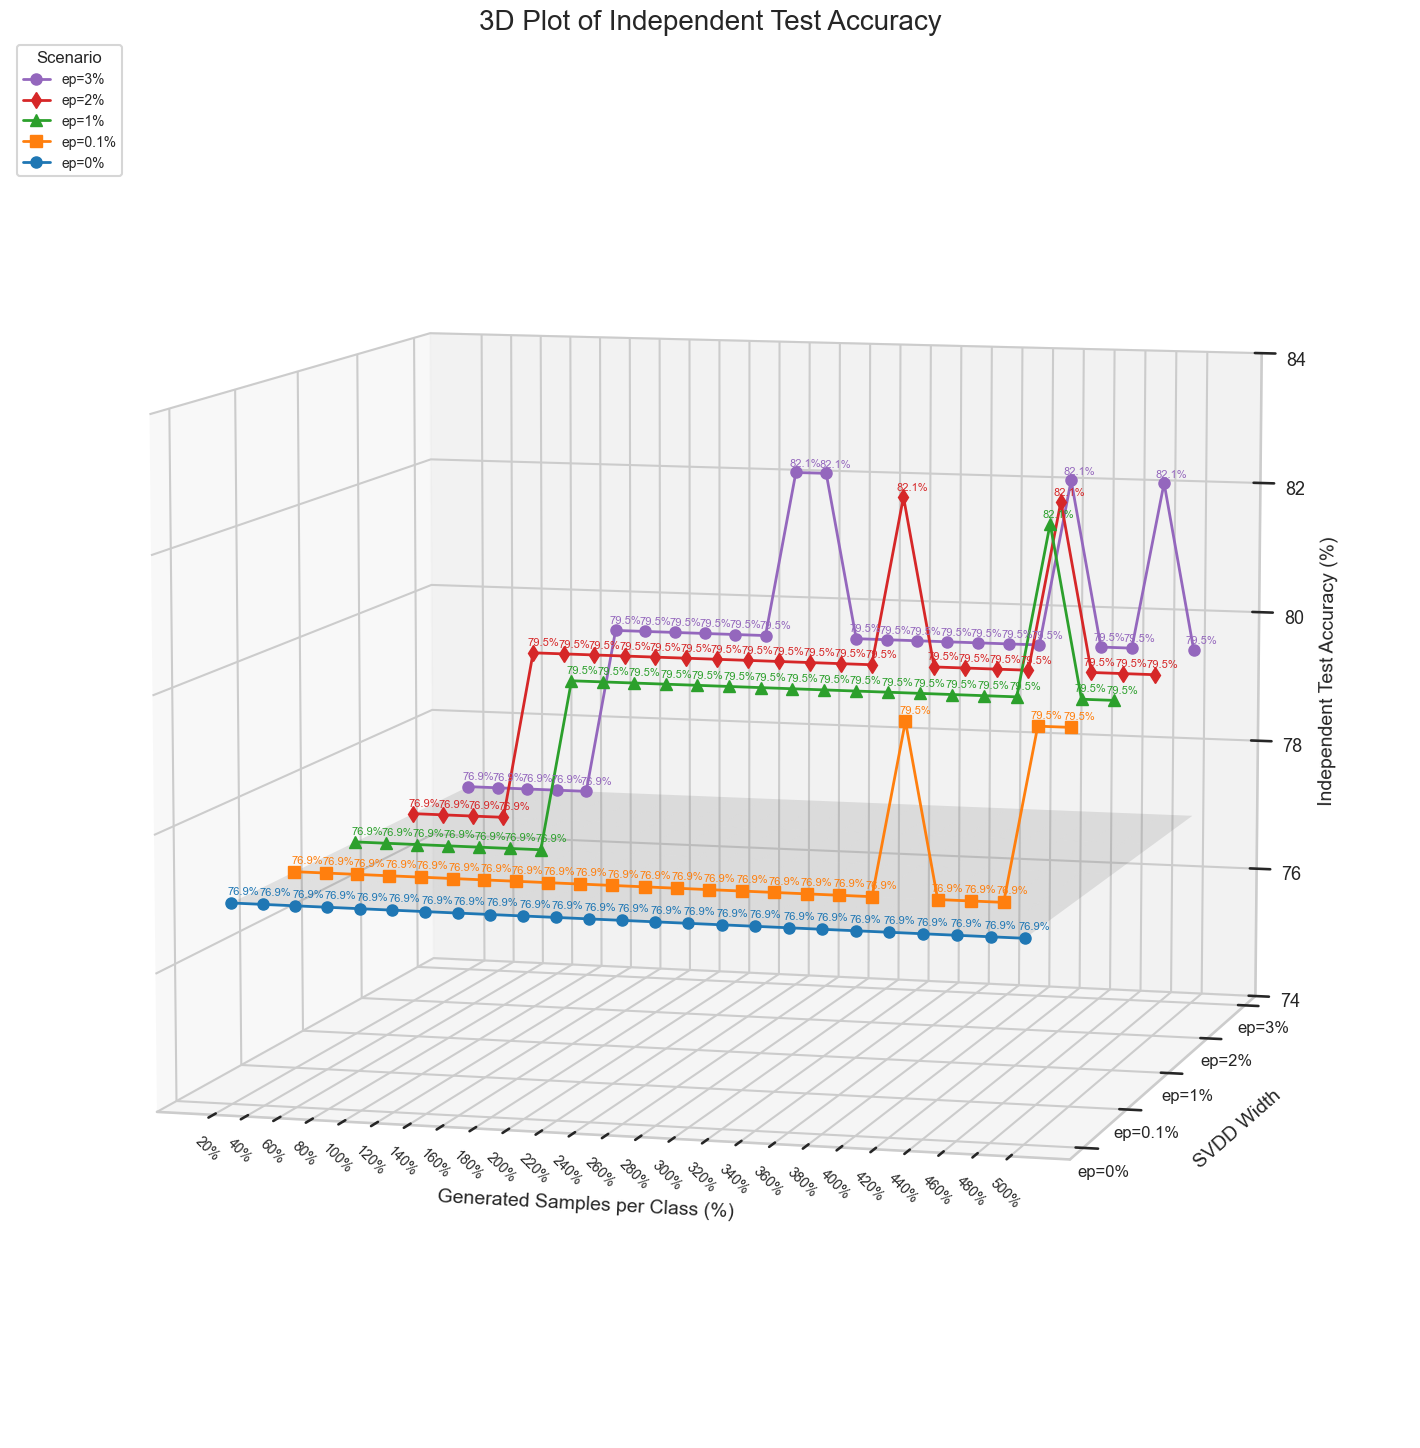

In [25]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

def load_histories(paths):
    
    histories = []
    for p in paths:
        if not os.path.exists(p):
            print(f"Warning: File not found: {p}")
            continue
        with open(p, 'rb') as f:
            hist = pickle.load(f)
            for key in ['gen_counts', 'loocv_scores', 'test_scores']:
                if key not in hist:
                    raise KeyError(f"Missing '{key}' in history loaded from {p}")
            histories.append(hist)
    if not histories:
        raise FileNotFoundError("No valid history files loaded. Please check the paths.")
    return histories



def plot_3d_lines(
    histories,
    metric_key,
    scenario_labels,
    title,
    z_label,
    elev=8,
    azim=-75,
    color_map='tab10',
    marker_map=('o','s','^','d'),
    plane_z=None
):
    
    gen_counts = np.array(histories[0]['gen_counts']) * 2  
    n_scenarios = len(histories)
    matrix = np.array([h[metric_key] for h in histories]) * 100

    sns.set_theme(style="whitegrid", context="talk")
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')


    ax.view_init(elev=elev, azim=azim)
    projM = ax.get_proj()

    # calculate depth
    depths = []
    for idx in range(n_scenarios):
        xs = gen_counts
        ys = np.full_like(xs, idx)
        zs = matrix[idx]
        ones = np.ones_like(xs)
        pts = np.vstack([xs, ys, zs, ones])
        proj = projM.dot(pts)
        depth = (proj[2] / proj[3]).mean()
        depths.append(depth)
    # reverse order
    order = np.argsort(depths)[::-1]

    cmap = plt.get_cmap(color_map)
    colors = [cmap(i) for i in range(n_scenarios)]

    # plot
    for idx in order:
        y_vals = np.full_like(gen_counts, idx)
        z_vals = matrix[idx]
        ax.plot(
            gen_counts, y_vals, z_vals,
            marker=marker_map[idx % len(marker_map)],
            markersize=8, linewidth=2,
            color=colors[idx], label=scenario_labels[idx]
        )
        for x, y, z in zip(gen_counts, y_vals, z_vals):
            ax.text(x, y+0.2, z, f"{z:.1f}%", fontsize=8,
                    ha='center', va='bottom', color=colors[idx])

    # horizontal plane
    if plane_z is not None:
        Xp, Yp = np.meshgrid(gen_counts, np.arange(n_scenarios))
        Zp = np.ones_like(Xp) * plane_z
        ax.plot_surface(Xp, Yp, Zp, color='gray', alpha=0.2, linewidth=0, shade=False)


    ax.set_xlabel('Generated Samples per Class (%)', fontsize=14, labelpad=20)
    ax.set_ylabel('SVDD Width', fontsize=14, labelpad=20)
    ax.set_zlabel(z_label, fontsize=14, labelpad=15)
    ax.set_zlim(74, 84)

    ax.tick_params(axis='z', which='major', labelsize=13, pad=10, length=5)

    ax.set_yticks(np.arange(n_scenarios))
    ax.set_yticklabels(scenario_labels, fontsize=12)
    ax.set_xticks(gen_counts)
    ax.set_xticklabels([f"{int(x)}%" for x in gen_counts], fontsize=10, rotation=-45)
    ax.set_title(title, fontsize=20)
    ax.legend(title='Scenario', fontsize=10, title_fontsize=12, loc='upper left')

    fig.subplots_adjust(bottom=0.18)
    plt.tight_layout()
    plt.show()





if __name__ == '__main__':
    paths = [
        '../result_LSVM/BD_MDD/BVAE/ep=0%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=0.1%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=1%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=2%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=3%/svm_loocv_test_history.pkl',
    ]
    histories = load_histories(paths)
    scenario_labels = [os.path.basename(os.path.dirname(p)) for p in paths if os.path.exists(p)]


    # Independent Test with plane
    plot_3d_lines(
        histories,
        metric_key='test_scores',
        scenario_labels=scenario_labels,
        title='3D Plot of Independent Test Accuracy',
        z_label='Independent Test Accuracy (%)',
        plane_z=76.92
    )


C:\Users\NESS-Kuan\AppData\Local\Temp\ipykernel_25392\714250518.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


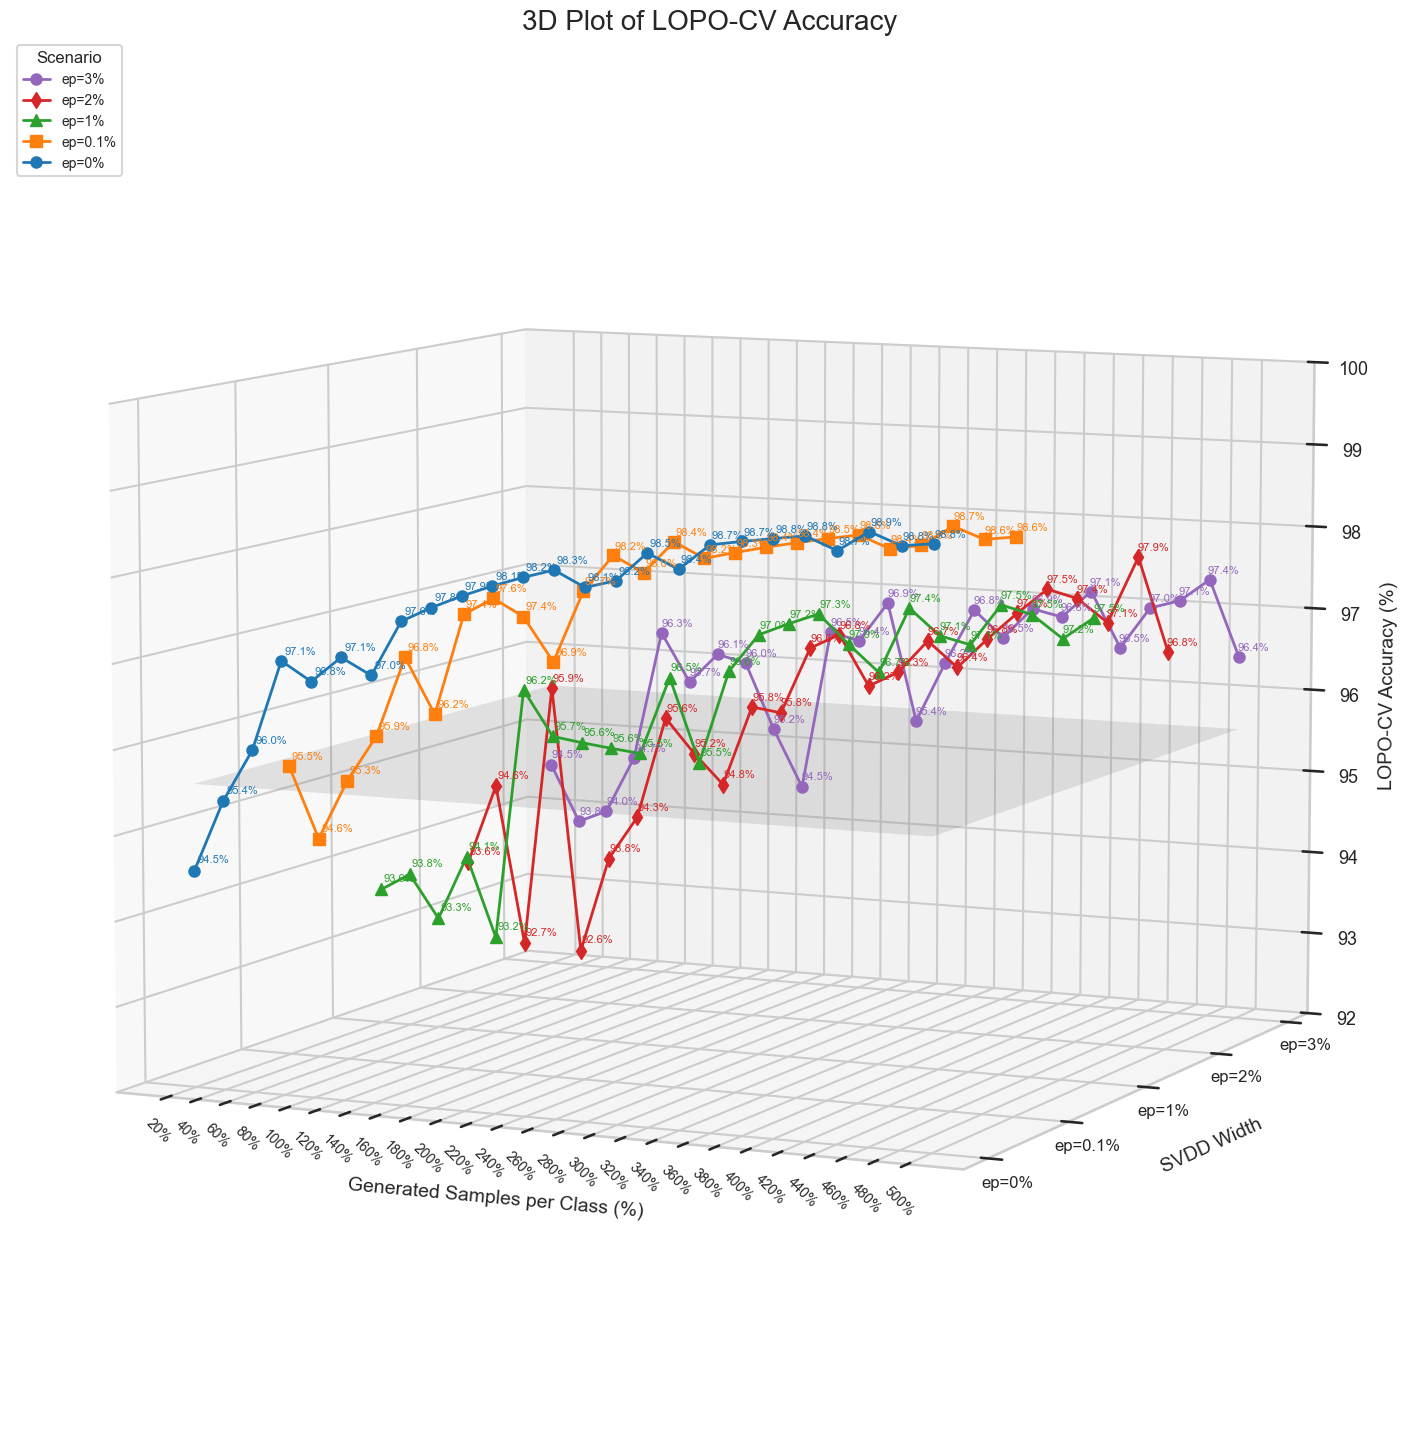

In [26]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

def load_histories(paths):
    
    histories = []
    for p in paths:
        if not os.path.exists(p):
            print(f"Warning: File not found: {p}")
            continue
        with open(p, 'rb') as f:
            hist = pickle.load(f)
            for key in ['gen_counts', 'loocv_scores', 'test_scores']:
                if key not in hist:
                    raise KeyError(f"Missing '{key}' in history loaded from {p}")
            histories.append(hist)
    if not histories:
        raise FileNotFoundError("No valid history files loaded. Please check the paths.")
    return histories



def plot_3d_lines(
    histories,
    metric_key,
    scenario_labels,
    title,
    z_label,
    elev=8,
    azim=-65,
    color_map='tab10',
    marker_map=('o','s','^','d'),
    plane_z=None
):
    
    gen_counts = np.array(histories[0]['gen_counts']) * 2  
    n_scenarios = len(histories)
    matrix = np.array([h[metric_key] for h in histories]) * 100

    sns.set_theme(style="whitegrid", context="talk")
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')


    ax.view_init(elev=elev, azim=azim)
    projM = ax.get_proj()

    # calculate depth
    depths = []
    for idx in range(n_scenarios):
        xs = gen_counts
        ys = np.full_like(xs, idx)
        zs = matrix[idx]
        ones = np.ones_like(xs)
        pts = np.vstack([xs, ys, zs, ones])
        proj = projM.dot(pts)
        depth = (proj[2] / proj[3]).mean()
        depths.append(depth)
    # reverse order
    order = np.argsort(depths)[::-1]

    cmap = plt.get_cmap(color_map)
    colors = [cmap(i) for i in range(n_scenarios)]

    # plot
    for idx in order:
        y_vals = np.full_like(gen_counts, idx)
        z_vals = matrix[idx]
        ax.plot(
            gen_counts, y_vals, z_vals,
            marker=marker_map[idx % len(marker_map)],
            markersize=8, linewidth=2,
            color=colors[idx], label=scenario_labels[idx]
        )
        for x, y, z in zip(gen_counts, y_vals, z_vals):
            ax.text(x, y+0.2, z, f"{z:.1f}%", fontsize=8,
                    ha='center', va='bottom', color=colors[idx])

    # horizontal plane
    if plane_z is not None:
        Xp, Yp = np.meshgrid(gen_counts, np.arange(n_scenarios))
        Zp = np.ones_like(Xp) * plane_z
        ax.plot_surface(Xp, Yp, Zp, color='gray', alpha=0.2, linewidth=0, shade=False)


    ax.set_xlabel('Generated Samples per Class (%)', fontsize=14, labelpad=20)
    ax.set_ylabel('SVDD Width', fontsize=14, labelpad=20)
    ax.set_zlabel(z_label, fontsize=14, labelpad=15)
    ax.set_zlim(92, 100)

    ax.tick_params(axis='z', which='major', labelsize=13, pad=10, length=5)

    ax.set_yticks(np.arange(n_scenarios))
    ax.set_yticklabels(scenario_labels, fontsize=12)
    ax.set_xticks(gen_counts)
    ax.set_xticklabels([f"{int(x)}%" for x in gen_counts], fontsize=10, rotation=-45)
    ax.set_title(title, fontsize=20)
    ax.legend(title='Scenario', fontsize=10, title_fontsize=12, loc='upper left')

    fig.subplots_adjust(bottom=0.18)
    plt.tight_layout()
    plt.show()





if __name__ == '__main__':
    paths = [
        '../result_LSVM/BD_MDD/BVAE/ep=0%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=0.1%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=1%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=2%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=3%/svm_loocv_test_history.pkl',
    ]
    histories = load_histories(paths)
    scenario_labels = [os.path.basename(os.path.dirname(p)) for p in paths if os.path.exists(p)]

    # LOPO-CV without plane
    plot_3d_lines(
        histories,
        metric_key='loocv_scores',
        scenario_labels=scenario_labels,
        title='3D Plot of LOPO-CV Accuracy',
        z_label='LOPO-CV Accuracy (%)',
        plane_z=95.56
    )




C:\Users\NESS-Kuan\AppData\Local\Temp\ipykernel_25392\3433523152.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


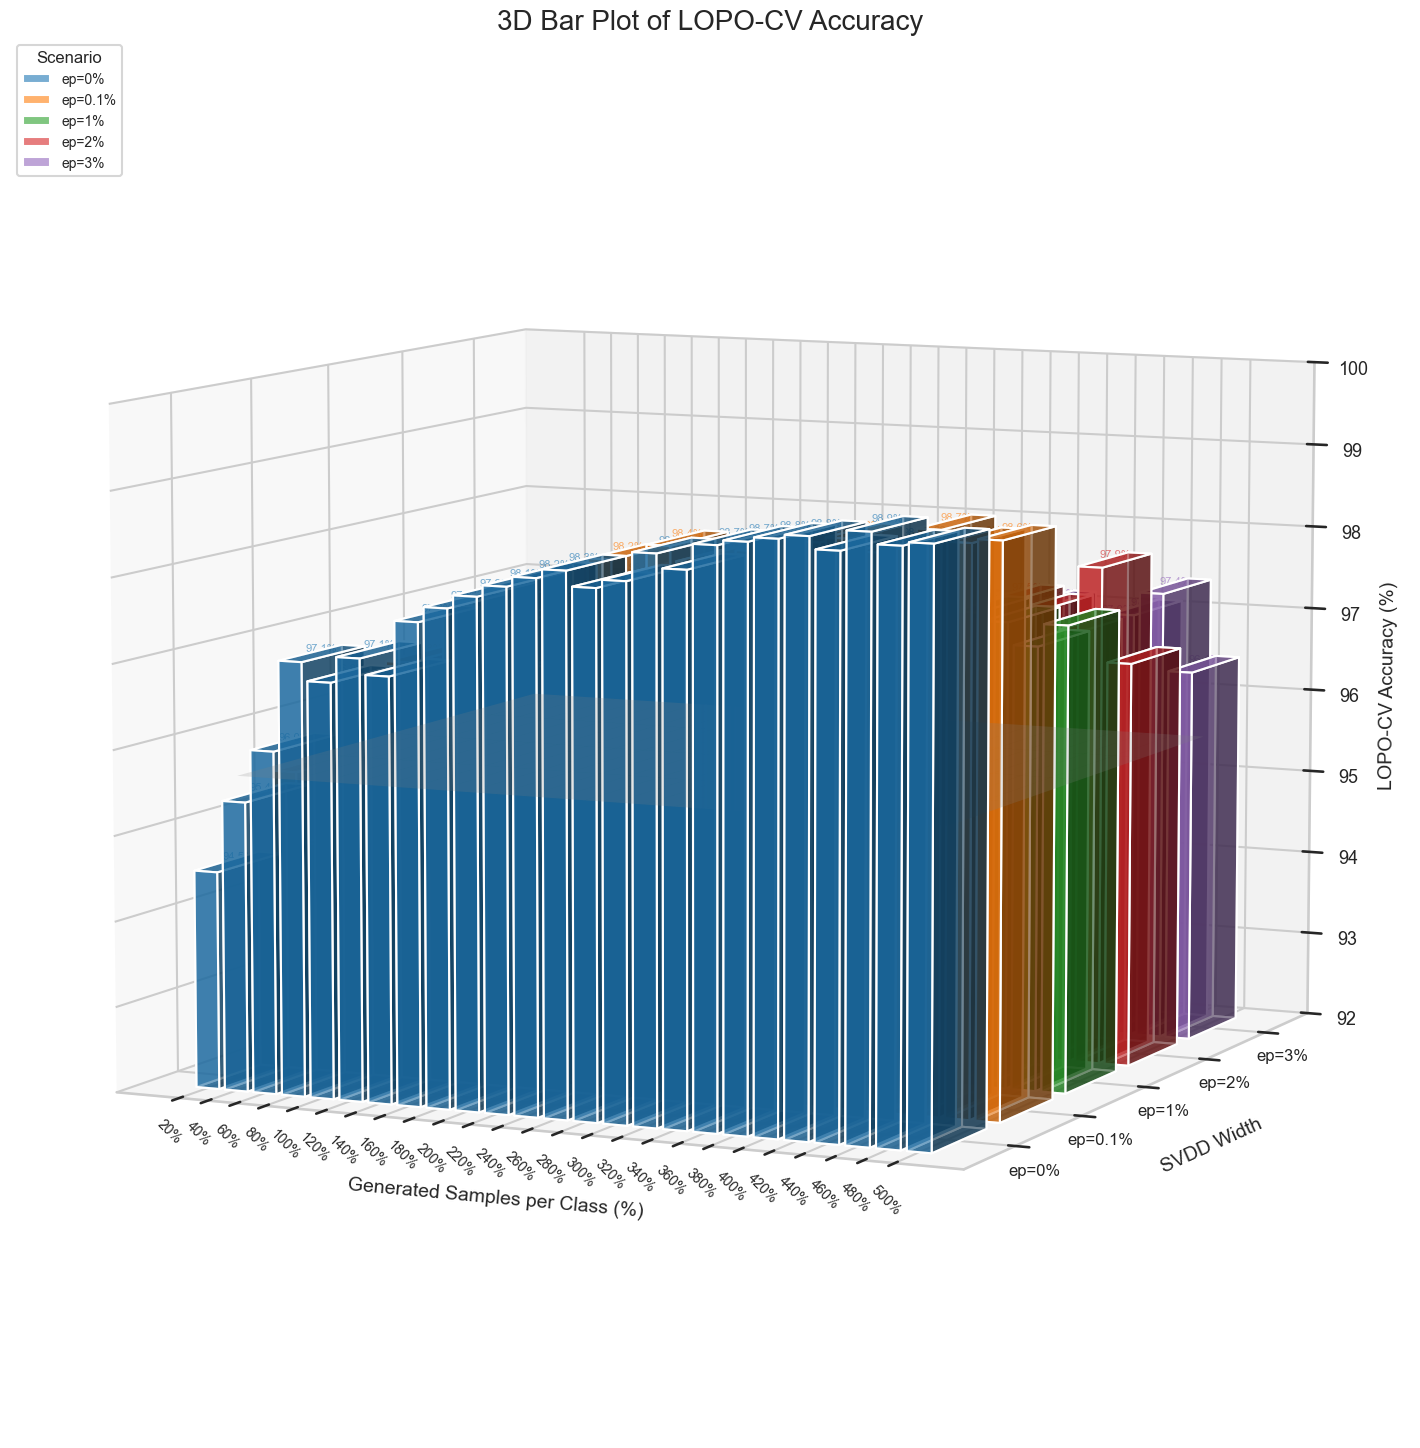

In [32]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.patches import Patch

def load_histories(paths):
  
    histories = []
    for p in paths:
        if not os.path.exists(p):
            print(f"Warning: File not found: {p}")
            continue
        with open(p, 'rb') as f:
            hist = pickle.load(f)
            for key in ['gen_counts', 'loocv_scores', 'test_scores']:
                if key not in hist:
                    raise KeyError(f"Missing '{key}' in history loaded from {p}")
            histories.append(hist)
    if not histories:
        raise FileNotFoundError("No valid history files loaded. Please check the paths.")
    return histories



def plot_3d_bars(
    histories,
    metric_key,
    scenario_labels,
    title,
    z_label,
    elev=8,
    azim=-65,
    color_map='tab10',
    plane_z=None
):
    
    gen_counts = np.array(histories[0]['gen_counts']) * 2  
    n_scenarios = len(histories)
    matrix = np.array([h[metric_key] for h in histories]) * 100

    sns.set_theme(style="whitegrid", context="talk")
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(elev=elev, azim=azim)
    ax.set_zlim(92, 100)
    z_base = ax.get_zlim()[0]  

 
    if len(gen_counts) > 1:
        dx = (gen_counts[1] - gen_counts[0]) * 0.8
    else:
        dx = 1
    dy = 0.8

    cmap = plt.get_cmap(color_map)
    base_colors = [cmap(i) for i in range(n_scenarios)]
    colors = [(r, g, b, 0.6) for (r, g, b, a) in base_colors]


    order = [i for i in range(n_scenarios) if i != 0] + [0]


    for idx in order:
        for x, z in zip(gen_counts, matrix[idx]):
            height = z - z_base
            ax.bar3d(
                x - dx/2, idx - dy/2, z_base,
                dx, dy, height,
                color=colors[idx], shade=True
            )
            ax.text(
                x, idx, z,
                f"{z:.1f}%",
                fontsize=8, ha='center', va='bottom',
                color=colors[idx]
            )

 
    if plane_z is not None:
        Xp, Yp = np.meshgrid(gen_counts, np.arange(n_scenarios))
        Zp = np.ones_like(Xp) * plane_z
        ax.plot_surface(Xp, Yp, Zp, color='gray', alpha=0.2, linewidth=0, shade=False)


    ax.set_xlabel('Generated Samples per Class (%)', fontsize=14, labelpad=20)
    ax.set_ylabel('SVDD Width', fontsize=14, labelpad=20)
    ax.set_zlabel(z_label, fontsize=14, labelpad=15)
    ax.tick_params(axis='z', which='major', labelsize=13, pad=10, length=5)
    ax.set_yticks(np.arange(n_scenarios))
    ax.set_yticklabels(scenario_labels, fontsize=12)
    ax.set_xticks(gen_counts)
    ax.set_xticklabels([f"{int(x)}%" for x in gen_counts], fontsize=10, rotation=-45)
    ax.set_title(title, fontsize=20)


    proxies = [Patch(facecolor=colors[i], label=scenario_labels[i]) for i in range(n_scenarios)]
    ax.legend(handles=proxies, title='Scenario', fontsize=10, title_fontsize=12, loc='upper left')

    fig.subplots_adjust(bottom=0.18)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    paths = [
        '../result_LSVM/BD_MDD/BVAE/ep=0%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=0.1%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=1%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=2%/svm_loocv_test_history.pkl',
        '../result_LSVM/BD_MDD/BVAE/ep=3%/svm_loocv_test_history.pkl',
    ]
    histories = load_histories(paths)
    scenario_labels = ['ep=0%', 'ep=0.1%', 'ep=1%', 'ep=2%', 'ep=3%']

    plot_3d_bars(
        histories,
        metric_key='loocv_scores',
        scenario_labels=scenario_labels,
        title='3D Bar Plot of LOPO-CV Accuracy',
        z_label='LOPO-CV Accuracy (%)',
        plane_z=95.56
    )
